# Analisis de los Barrios de Seatle

## Configuración inicial

Importar las configuraciones iniciales

In [1]:
print(">> Comienzo de importación")
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut 
import geocoder
import folium
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
print("Importación completada exitosamente <<")

>> Comienzo de importación
Importación completada exitosamente <<


## Recolección de los datos de Seatle

Se va a realizar una busqueda de los barrios de Seatle desde la web de wikipedia. Luego obtener sus coordenadas, exportar la información a un csv para futuro procesamiento, procesar esa información con la limpieza del dataframe. Por ultimo mostrar el mapa de Seatle.

In [2]:
#Obtener la informacion de los barrios desde wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle'
wiki_html = requests.get(url).text
soup = BeautifulSoup(wiki_html, 'html.parser')

data = []
for tr in soup.tbody.find_all('tr'):
    data.append([ td.get_text().strip() for td in tr.find_all('td') ])

data = data[1:128]

data_SEA_barrios = []
data_SEA_distritos = []

for row in range(len(data)):
    data_SEA_barrios.append(data[row][0])
    data_SEA_distritos.append(data[row][1])

#Se realiza ahora una limpieza de los datos ya que aparecen simbolos [ ] que ensucian los datos

#primero distritos
for row in range(len(data_SEA_distritos)):
    if '[' in data_SEA_distritos[row]:
        index_remove = data_SEA_distritos[row].index('[')
        data_SEA_distritos[row] = data_SEA_distritos[row][0:index_remove]
    
#segundo los barrios    
for row in range(len(data_SEA_barrios)):
    if '[' in data_SEA_barrios[row]:
        index_remove = data_SEA_barrios[row].index('[')
        data_SEA_barrios[row] = data_SEA_barrios[row][0:index_remove]

# Agregamos los nombres de las columnas y lo transformamos en un data set
seatle_data = pd.DataFrame(columns=['Barrio','Distrito'])
for item in range(len(data_SEA_barrios)):
    seatle_data = seatle_data.append({'Barrio': data_SEA_barrios[item],
                             'Distrito': data_SEA_distritos[item]}, ignore_index=True)

seatle_data.head()

/var/folders/79/4l20n_4n3dn2twlpxr55cbg80000gn/T/ipykernel_23232/1137231105.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seatle_data = seatle_data.append({'Barrio': data_SEA_barrios[item],
/var/folders/79/4l20n_4n3dn2twlpxr55cbg80000gn/T/ipykernel_23232/1137231105.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seatle_data = seatle_data.append({'Barrio': data_SEA_barrios[item],
/var/folders/79/4l20n_4n3dn2twlpxr55cbg80000gn/T/ipykernel_23232/1137231105.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seatle_data = seatle_data.append({'Barrio': data_SEA_barrios[item],
/var/folders/79/4l20n_4n3dn2twlpxr55cbg80000gn/T/ipykernel_23232/1137231105.py:36: FutureWarning: The frame.append method is deprecated and wi

,Barrio,Distrito
0,North Seattle,Seattle
1,Broadview,North Seattle
2,Bitter Lake,North Seattle
3,North Beach / Blue Ridge,North Seattle
4,Crown Hill,North Seattle


Con el data set obtenido vamos a hacer la busqueda de las coordenadas de cada barrio y distritos usando geocoder

In [3]:
# defino la función lat_lng para obtener la longitud y latitud para cierta direccion o barrio
def get_latlng(address):
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Washington'.format(address)) 
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [4]:
latitud = []
longitud = []

# Uso la funcion definida anteriormente get_latlng para obtener las coordenadas del dataset
for direccion in (seatle_data["Barrio"]):
    if get_latlng(direccion) != None:
        loc = get_latlng(direccion)
        # devuelvo las coordenadas
        latitud.append(loc[0])
        longitud.append(loc[1])
        
        #Si no hay coordenadas, agrego que no existe
    else:
        print(i + ", WA")
        latitud.append(np.nan)
        longitud.append(np.nan)

In [5]:
# Agregamos la informacion obtenida al data frama
seatle_data["Latitud"] = latitud
seatle_data["Longitud"] = longitud

#Limpiamos las columnas que no tienen informacion de coordenadas
seatle_data.dropna(subset=['Latitud'], inplace=True)
seatle_data.reset_index(drop=True, inplace=True)
seatle_data.head()

,Barrio,Distrito,Latitud,Longitud
0,North Seattle,Seattle,47.643724,-122.302965
1,Broadview,North Seattle,47.722380,-122.364980
2,Bitter Lake,North Seattle,47.718680,-122.350300
3,North Beach / Blue Ridge,North Seattle,47.700440,-122.384180
4,Crown Hill,North Seattle,47.695200,-122.374100


Generar todos estos datos lleva mucho tiempo de procesamiento, para ahorrar tiempo de procesamiento lo que haremos es guardar esta informacion en un archivo csv.

In [6]:
seatle_data.to_csv(r'data_barrios_seatle', index = False)

In [7]:
# Importamos el data frame guardado en csv
seatle_data = pd.read_csv(r'data_barrios_seatle')
seatle_data.dropna(subset=['Latitud'], inplace=True)
seatle_data.reset_index(drop=True, inplace=True)
seatle_data.head()

,Barrio,Distrito,Latitud,Longitud
0,North Seattle,Seattle,47.643724,-122.302965
1,Broadview,North Seattle,47.722380,-122.364980
2,Bitter Lake,North Seattle,47.718680,-122.350300
3,North Beach / Blue Ridge,North Seattle,47.700440,-122.384180
4,Crown Hill,North Seattle,47.695200,-122.374100


Contamos la cantidad de barrios y distritos tiene el conjunto de datos

In [8]:
print('El conjunto de datos tiene {} distritos y {} barrios.'.format(
        len(seatle_data['Distrito'].unique()),
        seatle_data.shape[0]
    )
)


El conjunto de datos tiene 32 distritos y 127 barrios.


### Creación del mapa de Seatle con los Barrios y Distritos

In [9]:
# Get the geographical coordinates of Seattle
direccion = 'Seattle, WA'

geolocator = Nominatim(user_agent="seattle_explorer")
locacion_seatle = geolocator.geocode(direccion)
latitude_seattle = locacion_seatle.latitude
longitude_seattle = locacion_seatle.longitude
print('Coordenadas de Seatle {}, {}.'.format(latitude_seattle, longitude_seattle))

Coordenadas de Seatle 47.6038321, -122.330062.


In [10]:
# Creamos el mapa 
map = folium.Map(location=[latitude_seattle, longitude_seattle], zoom_start=10)

# add markers to map
for lat, lng, ciudad, barrios in zip(seatle_data['Latitud'], seatle_data['Longitud'], seatle_data['Distrito'], seatle_data['Barrio']):
    label = '{}, {}'.format(barrios, ciudad)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

## Analisis de los crimenes dentro de Seatle

In [11]:
data_crimenes = pd.read_csv('Crime_Data.csv')
data_crimenes.head()

,Report Number,Offense ID,Offense Start DateTime,Offense End DateTime,Report DateTime,Group A B,Crime Against Category,Offense Parent Group,Offense,Offense Code,Precinct,Sector,Beat,MCPP,100 Block Address,Longitude,Latitude
0,2020-232722,14749627332,8/5/2020 22:03,8/5/2020 22:03,8/6/2020 1:10,A,PROPERTY,BURGLARY/BREAKING&ENTERING,Burglary/Breaking & Entering,220,E,E,E1,CAPITOL HILL,6XX BLOCK OF BELMONT AVE E,-122.324039,47.624705
1,2020-232740,14746508904,8/5/2020 22:45,8/5/2020 23:30,8/5/2020 23:31,A,PERSON,ASSAULT OFFENSES,Simple Assault,13B,E,C,C3,CENTRAL AREA/SQUIRE PARK,9XX BLOCK OF 25TH AVE,-122.300138,47.610795
2,2020-232748,14746068011,8/5/2020 21:00,8/5/2020 23:00,8/5/2020 23:26,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,E,E,E2,CAPITOL HILL,15XX BLOCK OF 12TH AVE,-122.316845,47.614684
3,2020-232689,14745070199,8/5/2020 21:10,NaN,8/5/2020 22:59,A,PERSON,ASSAULT OFFENSES,Simple Assault,13B,SW,F,F1,NORTH DELRIDGE,54XX BLOCK OF DELRIDGE WAY SW,-122.362976,47.552820
4,2020-232654,14742137960,8/4/2020 0:00,8/4/2020 23:59,8/5/2020 22:18,A,PROPERTY,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,23G,W,Q,Q2,QUEEN ANNE,24XX BLOCK OF 4TH AVE W,-122.362259,47.640821


In [12]:
data_crimenes.shape

(76931, 17)

In [13]:
data_crimenes_2020 = data_crimenes[data_crimenes['Report DateTime']>'01/01/2020']
data_crimenes_2020.shape

(76931, 17)

In [14]:
# Limpio las columnas y me quedo solamente con las que se necesitan
crimenes = data_crimenes_2020[['Offense Parent Group','Offense','MCPP','Latitude','Longitude']]
# rename the column titles
crimenes.rename(columns={"Offense Parent Group": "Offense Category", "MCPP": "District"}, inplace=True)
crimenes.head()

/var/folders/79/4l20n_4n3dn2twlpxr55cbg80000gn/T/ipykernel_23232/221445115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimenes.rename(columns={"Offense Parent Group": "Offense Category", "MCPP": "District"}, inplace=True)


,Offense Category,Offense,District,Latitude,Longitude
0,BURGLARY/BREAKING&ENTERING,Burglary/Breaking & Entering,CAPITOL HILL,47.624705,-122.324039
1,ASSAULT OFFENSES,Simple Assault,CENTRAL AREA/SQUIRE PARK,47.610795,-122.300138
2,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,CAPITOL HILL,47.614684,-122.316845
3,ASSAULT OFFENSES,Simple Assault,NORTH DELRIDGE,47.552820,-122.362976
4,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,QUEEN ANNE,47.640821,-122.362259


In [15]:
records = str(crimenes.shape[0])
crimenes_tipos = str(len(crimenes["Offense"].unique()))
numero_distritos = str(len(crimenes["District"].unique()))
print("El conjunto de datos de crimenes tiene {} records con {} tipos diferentes de ofensas en {} distritos.".format(records,crimenes_tipos,numero_distritos))

El conjunto de datos de crimenes tiene 76931 records con 55 tipos diferentes de ofensas en 59 distritos.


In [16]:
# Chequeo si hay datos que falten en alguna de las columnas
missingdata = crimenes.isnull()
for column in missingdata.columns.values.tolist():
    print(column)
    print(missingdata[column].value_counts())
    print("")


Offense Category
False    76931
Name: Offense Category, dtype: int64

Offense
False    76931
Name: Offense, dtype: int64

District
False    76931
Name: District, dtype: int64

Latitude
False    76931
Name: Latitude, dtype: int64

Longitude
False    76931
Name: Longitude, dtype: int64



### Analisis exploratorio de los datos de crimenes en Seatle

Revisamos la cantidad de veces que ocurrieron cada una de las ofensas registradas

In [17]:
crimenes["Offense"].value_counts()

Theft From Motor Vehicle                       10035
Identity Theft                                  9442
Burglary/Breaking & Entering                    8981
All Other Larceny                               6261
Destruction/Damage/Vandalism of Property        6111
Simple Assault                                  5164
Motor Vehicle Theft                             4387
Shoplifting                                     3881
Trespass of Real Property                       3224
Intimidation                                    3011
Aggravated Assault                              2769
Theft From Building                             2048
Theft of Motor Vehicle Parts or Accessories     1720
Robbery                                         1485
Driving Under the Influence                     1269
Drug/Narcotic Violations                        1217
Credit Card/Automated Teller Machine Fraud       923
False Pretenses/Swindle/Confidence Game          758
Stolen Property Offenses                      

Ahora luego de ver estos datos, nos preguntamos cuantos de estos ocurren por distrito

In [18]:
# Looking at the number of crimes per offense by district
crimenes_distritos = pd.DataFrame(crimenes.groupby(['District','Offense']).size().rename('Count of Offense').reset_index())
crimenes_distritos.head(20)

,District,Offense,Count of Offense
0,ALASKA JUNCTION,Aggravated Assault,35
1,ALASKA JUNCTION,All Other Larceny,99
2,ALASKA JUNCTION,Bad Checks,2
3,ALASKA JUNCTION,Burglary/Breaking & Entering,166
4,ALASKA JUNCTION,Counterfeiting/Forgery,7
5,ALASKA JUNCTION,Credit Card/Automated Teller Machine Fraud,17
6,ALASKA JUNCTION,Destruction/Damage/Vandalism of Property,106
7,ALASKA JUNCTION,Driving Under the Influence,34
8,ALASKA JUNCTION,Drug/Narcotic Violations,7
9,ALASKA JUNCTION,Embezzlement,1


In [19]:
# Creo tabla pivot de la tabla anterior
crime_pivot = crimenes_distritos.pivot_table("Count of Offense","District","Offense")

# Agrego columnar Total que suma la cantidad total de ofensas por distrito
crime_pivot["Total"] = crime_pivot.sum(axis=1)
crime_pivot = crime_pivot.iloc[1: , :]
crime_pivot.head()

Offense,Aggravated Assault,All Other Larceny,Animal Cruelty,Arson,Assisting or Promoting Prostitution,Bad Checks,Bribery,Burglary/Breaking & Entering,Counterfeiting/Forgery,Credit Card/Automated Teller Machine Fraud,...,Stolen Property Offenses,Theft From Building,Theft From Coin-Operated Machine or Device,Theft From Motor Vehicle,Theft of Motor Vehicle Parts or Accessories,Trespass of Real Property,Weapon Law Violations,Welfare Fraud,Wire Fraud,Total
District,,,,,,,,,,,,,,,,,,,,,
ALKI,9.0,44.0,NaN,NaN,NaN,NaN,NaN,38.0,1.0,4.0,...,NaN,5.0,NaN,41.0,5.0,6.0,1.0,1.0,6.0,373.0
BALLARD NORTH,23.0,151.0,NaN,5.0,NaN,4.0,NaN,165.0,9.0,22.0,...,3.0,35.0,NaN,257.0,52.0,15.0,2.0,1.0,18.0,1752.0
BALLARD SOUTH,76.0,314.0,NaN,5.0,NaN,4.0,NaN,485.0,26.0,45.0,...,22.0,67.0,2.0,492.0,89.0,100.0,8.0,1.0,9.0,3004.0
BELLTOWN,99.0,114.0,NaN,1.0,NaN,1.0,NaN,259.0,9.0,19.0,...,11.0,78.0,1.0,249.0,8.0,79.0,16.0,NaN,11.0,1762.0
BITTERLAKE,61.0,125.0,NaN,NaN,NaN,1.0,1.0,139.0,5.0,27.0,...,8.0,34.0,1.0,196.0,44.0,42.0,5.0,1.0,7.0,1457.0


Obtenemos la informacion descriptiva del conjunto de datos

In [20]:
crime_pivot.describe()

Offense,Aggravated Assault,All Other Larceny,Animal Cruelty,Arson,Assisting or Promoting Prostitution,Bad Checks,Bribery,Burglary/Breaking & Entering,Counterfeiting/Forgery,Credit Card/Automated Teller Machine Fraud,...,Stolen Property Offenses,Theft From Building,Theft From Coin-Operated Machine or Device,Theft From Motor Vehicle,Theft of Motor Vehicle Parts or Accessories,Trespass of Real Property,Weapon Law Violations,Welfare Fraud,Wire Fraud,Total
count,58.000000,58.000000,15.000000,40.000000,2.0,32.000000,1.0,58.000000,51.000000,54.000000,...,50.000000,54.000000,18.000000,58.000000,57.000000,57.000000,54.000000,17.000000,52.000000,58.000000
mean,47.137931,106.241379,1.600000,3.650000,1.0,2.250000,1.0,151.982759,8.313725,16.777778,...,12.420000,36.907407,1.500000,170.948276,29.526316,56.052632,11.000000,1.117647,7.576923,1304.810345
std,51.929253,90.083258,0.910259,2.787794,0.0,1.741338,NaN,170.363851,9.120286,17.195509,...,14.791186,47.208597,0.618347,166.164727,26.288988,86.553539,15.263719,0.332106,5.696047,1222.909279
min,2.000000,6.000000,1.000000,1.000000,1.0,1.000000,1.0,2.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,35.000000
25%,14.250000,41.000000,1.000000,1.000000,1.0,1.000000,1.0,38.250000,2.000000,5.000000,...,4.000000,7.000000,1.000000,51.000000,10.000000,9.000000,3.000000,1.000000,3.000000,483.000000
50%,28.000000,80.000000,1.000000,4.000000,1.0,1.500000,1.0,85.500000,5.000000,8.500000,...,6.500000,17.000000,1.000000,115.000000,22.000000,19.000000,5.500000,1.000000,6.000000,851.500000
75%,62.500000,146.750000,2.000000,5.000000,1.0,3.000000,1.0,199.750000,9.500000,22.000000,...,18.500000,43.500000,2.000000,238.500000,44.000000,70.000000,12.000000,1.000000,9.500000,1759.500000
max,279.000000,360.000000,4.000000,15.000000,1.0,7.000000,1.0,799.000000,41.000000,66.000000,...,86.000000,209.000000,3.000000,843.000000,122.000000,466.000000,91.000000,2.000000,23.000000,5344.000000


Creamos un grafico de box plot para que sea de mejor visualizacion

<AxesSubplot: >

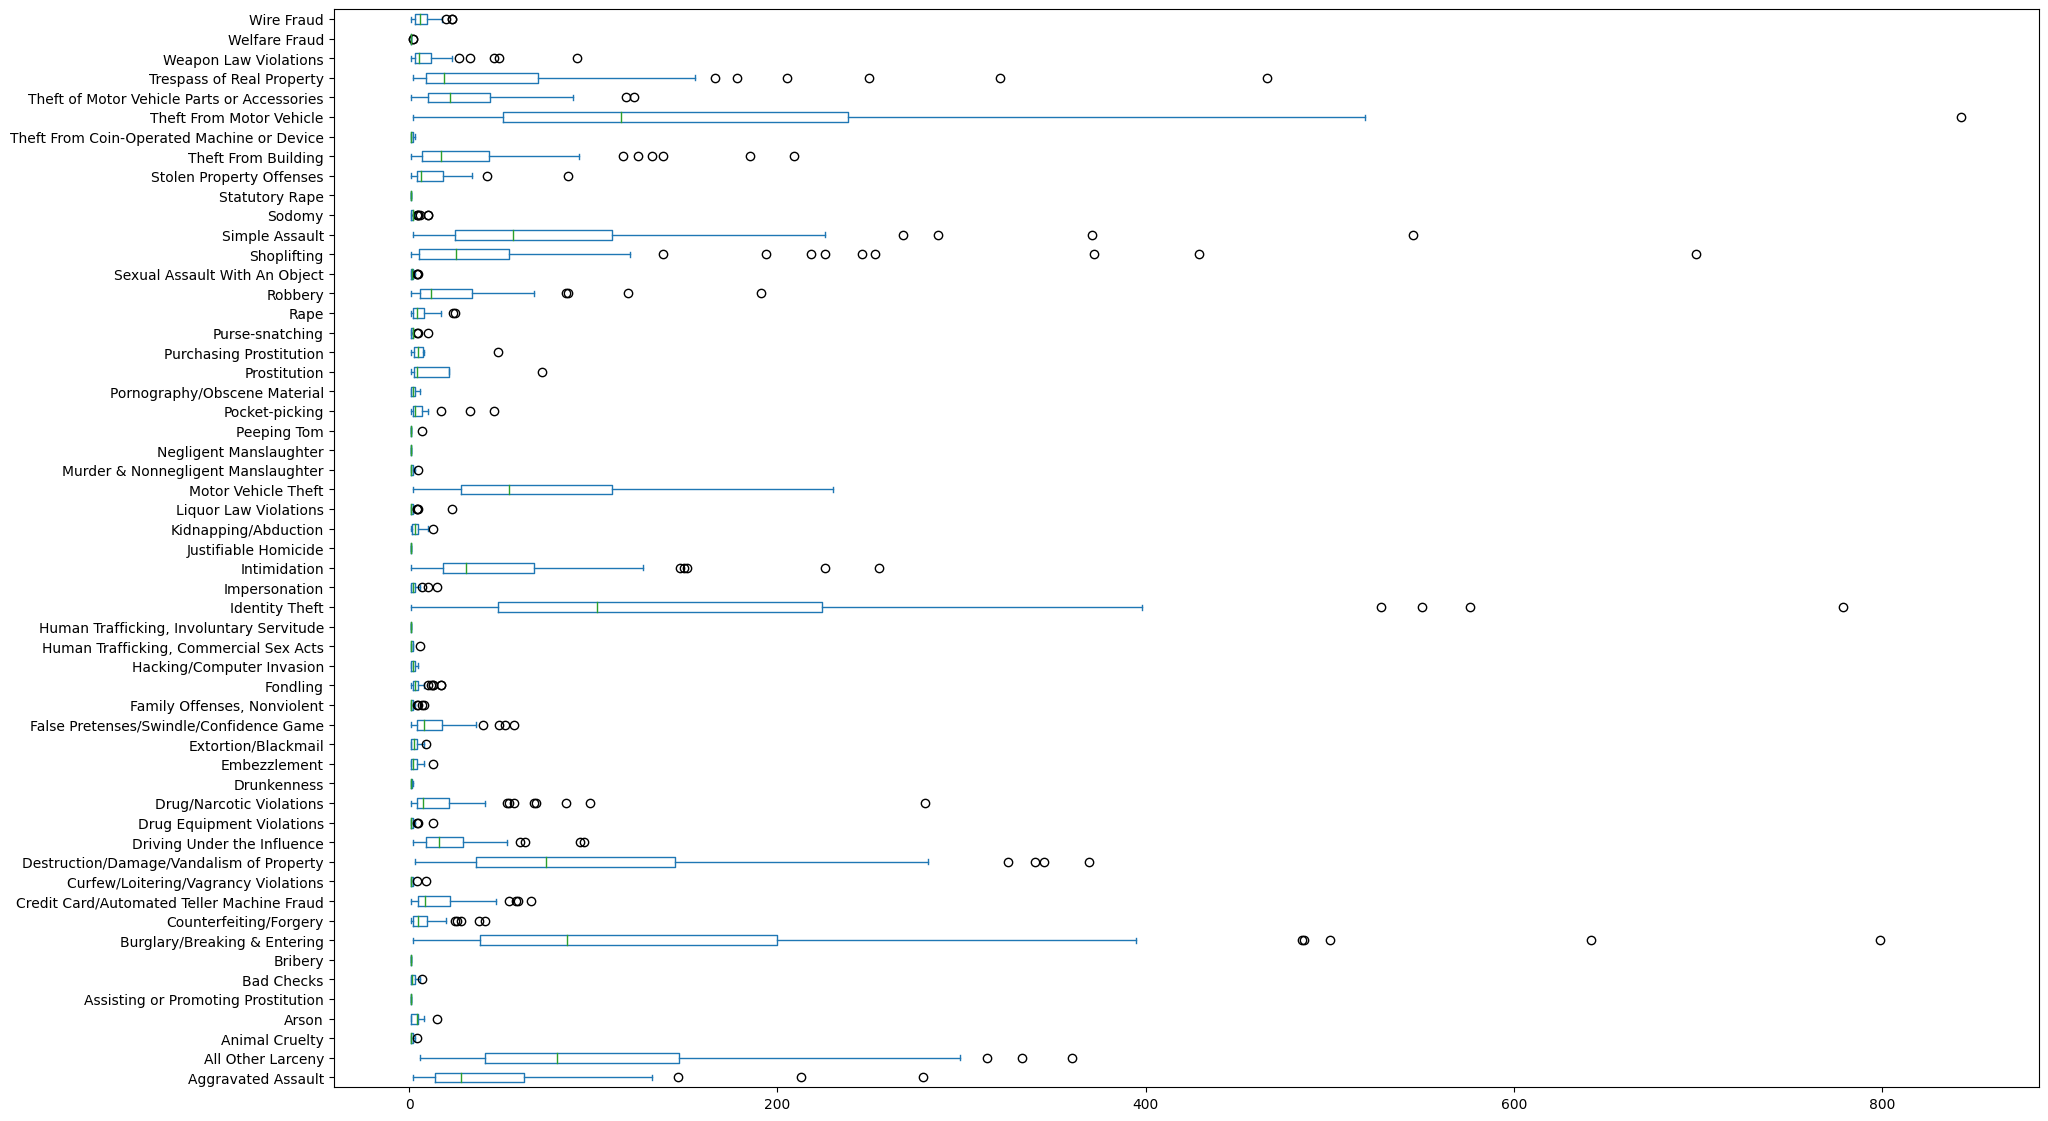

In [21]:
crime_pivot0 = crime_pivot.iloc[:,:-1] # elimino la columna totales
crime_pivot0.plot(kind='box', vert=False, figsize=[22,14])

#### Analisis de los Barrios con mas crimenes y menos crimenes en Seatle

In [22]:
# Creo un nuevo conjunto de datos ordenados de forma descendente por numero de ofensas
crimenes_ordenados = pd.DataFrame(crime_pivot['Total'].sort_values(ascending=False))

10 Barrios con mayor indice de crimenes

In [23]:
crimenes_ordenados.head(10)

,Total
District,
DOWNTOWN COMMERCIAL,5344.0
QUEEN ANNE,4481.0
CAPITOL HILL,4464.0
NORTHGATE,3978.0
SLU/CASCADE,3235.0
UNIVERSITY,3192.0
ROOSEVELT/RAVENNA,3071.0
BALLARD SOUTH,3004.0
FIRST HILL,2548.0


10 Barrios con menor indice de crimenes

In [24]:
crimenes_ordenados.tail(10)

,Total
District,
ALKI,373.0
MADISON PARK,320.0
HILLMAN CITY,307.0
SOUTH BEACON HILL,294.0
SOUTH DELRIDGE,260.0
GENESEE,190.0
EASTLAKE - EAST,119.0
PIGEON POINT,86.0
COMMERCIAL DUWAMISH,49.0


In [25]:
# Combinamos el conjunto de datos de los 10 peores y 10 mejores barrios
crimenes_combinados = pd.concat([crimenes_ordenados.head(10), crimenes_ordenados.tail(10)]).sort_values(by=["Total"], ascending=False)
crimenes_combinados

,Total
District,
DOWNTOWN COMMERCIAL,5344.0
QUEEN ANNE,4481.0
CAPITOL HILL,4464.0
NORTHGATE,3978.0
SLU/CASCADE,3235.0
UNIVERSITY,3192.0
ROOSEVELT/RAVENNA,3071.0
BALLARD SOUTH,3004.0
FIRST HILL,2548.0


Visualizacion de los datos en forma de grafica de barras

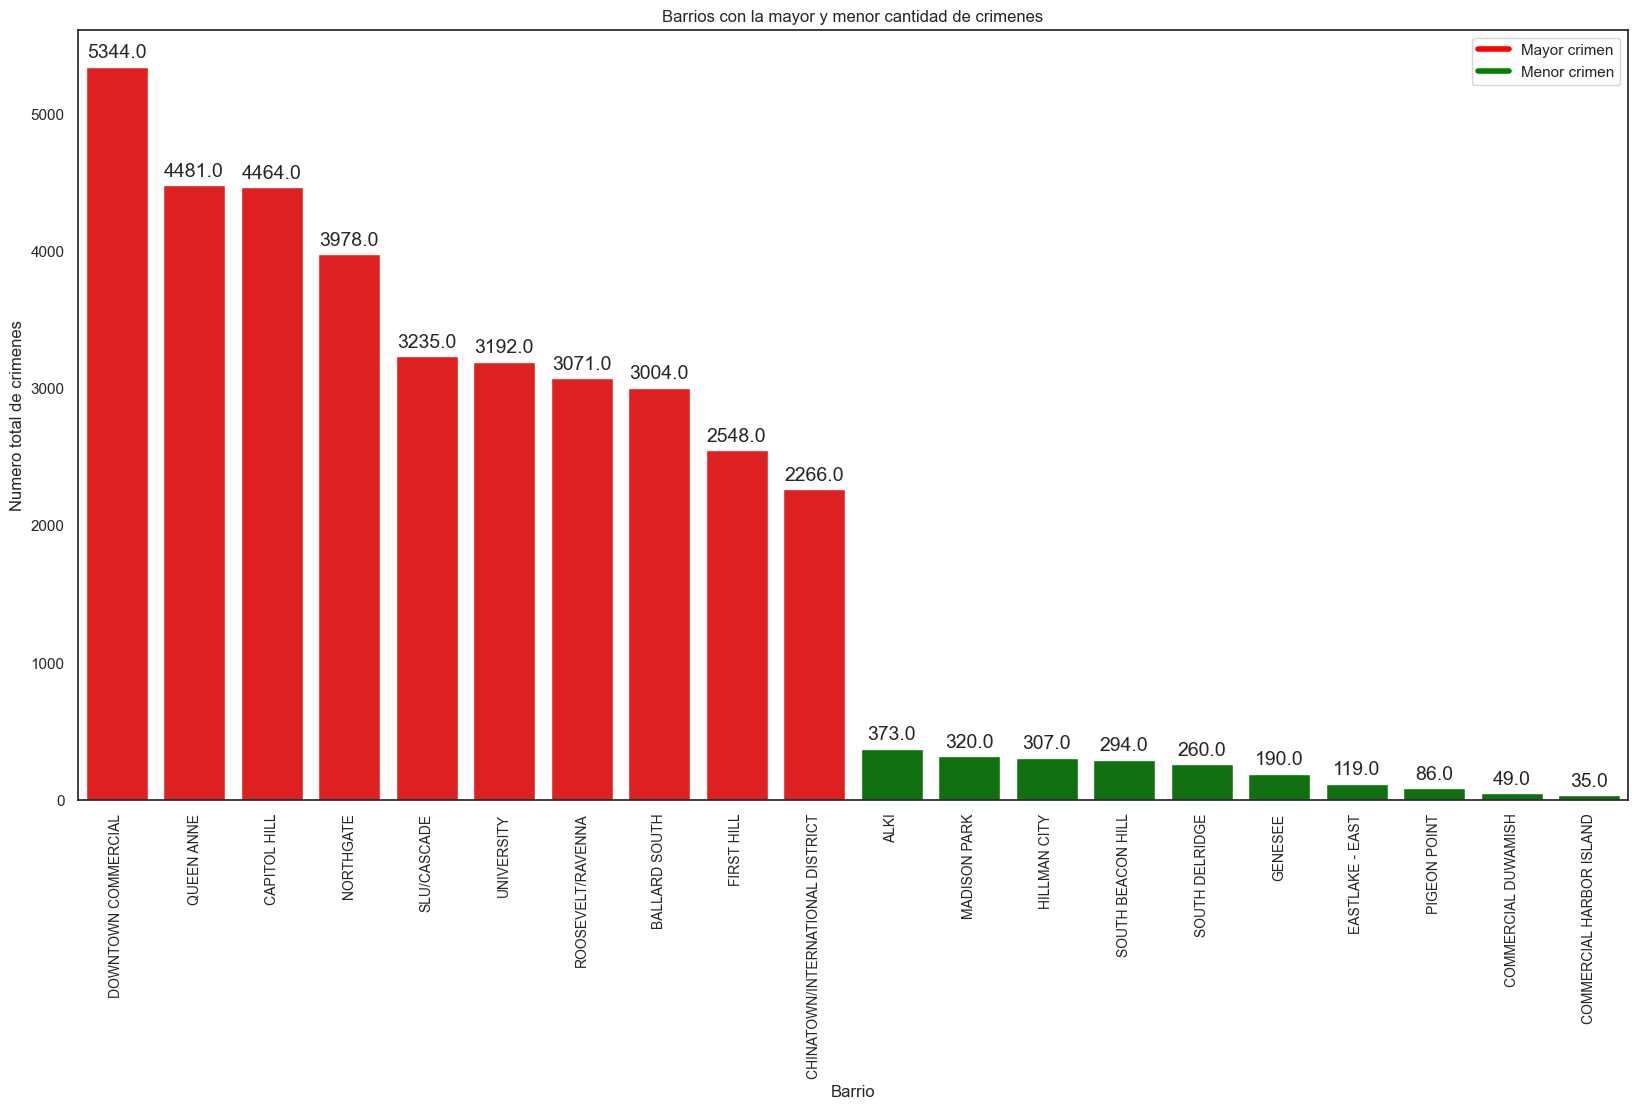

In [26]:
sns.set(style="white")

# creo la figura de matplotlib
fig, ax = plt.subplots(figsize=(20, 10))
colores = ["red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "green", "green", "green", "green", "green", "green", "green", "green", "green", "green", "green"]
custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4)]

# plot de la grafica de los numeros totales de crimenes en cada barrio
grafico = sns.barplot(x=crimenes_combinados.index, y="Total", data=crimenes_combinados, palette=colores)

# nombre de los ejes
ax.set_title('Barrios con la mayor y menor cantidad de crimenes')
ax.set(ylabel="Numero total de crimenes", xlabel="Barrio")
ax.legend(custom_lines, ['Mayor crimen', 'Menor crimen'])

# rotamos la xticklabels
grafico.set_xticklabels(grafico.get_xticklabels(),
                        rotation=90,
                        fontweight='light',
                        fontsize='small'
                        )

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

### Cluster de distritos segun los datos de crimenes

Se va a utilizar one hot encoding para convertir nuestro conjunto de datos de crimenes que es categorico en un vector binario.

In [27]:
# one hot encoding
wa_onehot = pd.get_dummies(crimenes[["Offense"]], prefix="", prefix_sep="")

# agrego la columna de distritos
wa_onehot["Distritos"] = crimenes["District"]

# muevo la columna al primer lugar
wa_onehot_col = [wa_onehot.columns[-1]] + list(wa_onehot.columns[:-1])
wa_onehot = wa_onehot[wa_onehot_col]

print(wa_onehot.shape)
wa_onehot.head()

(76931, 56)


,Distritos,Aggravated Assault,All Other Larceny,Animal Cruelty,Arson,Assisting or Promoting Prostitution,Bad Checks,Bribery,Burglary/Breaking & Entering,Counterfeiting/Forgery,...,Statutory Rape,Stolen Property Offenses,Theft From Building,Theft From Coin-Operated Machine or Device,Theft From Motor Vehicle,Theft of Motor Vehicle Parts or Accessories,Trespass of Real Property,Weapon Law Violations,Welfare Fraud,Wire Fraud
0,CAPITOL HILL,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,CENTRAL AREA/SQUIRE PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CAPITOL HILL,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NORTH DELRIDGE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,QUEEN ANNE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Buscamos el mean luego de agrupar por distrito

In [28]:
wa_grouped = wa_onehot.groupby(["Distritos"]).mean().reset_index()
print(wa_grouped.shape)
wa_grouped.head()

(59, 56)


,Distritos,Aggravated Assault,All Other Larceny,Animal Cruelty,Arson,Assisting or Promoting Prostitution,Bad Checks,Bribery,Burglary/Breaking & Entering,Counterfeiting/Forgery,...,Statutory Rape,Stolen Property Offenses,Theft From Building,Theft From Coin-Operated Machine or Device,Theft From Motor Vehicle,Theft of Motor Vehicle Parts or Accessories,Trespass of Real Property,Weapon Law Violations,Welfare Fraud,Wire Fraud
0,ALASKA JUNCTION,0.027955,0.079073,0.0,0.000000,0.0,0.001597,0.0,0.132588,0.005591,...,0.000000,0.001597,0.043930,0.000000,0.095847,0.029553,0.023163,0.004792,0.000000,0.006390
1,ALKI,0.024129,0.117962,0.0,0.000000,0.0,0.000000,0.0,0.101877,0.002681,...,0.000000,0.000000,0.013405,0.000000,0.109920,0.013405,0.016086,0.002681,0.002681,0.016086
2,BALLARD NORTH,0.013128,0.086187,0.0,0.002854,0.0,0.002283,0.0,0.094178,0.005137,...,0.000000,0.001712,0.019977,0.000000,0.146689,0.029680,0.008562,0.001142,0.000571,0.010274
3,BALLARD SOUTH,0.025300,0.104527,0.0,0.001664,0.0,0.001332,0.0,0.161451,0.008655,...,0.000333,0.007324,0.022304,0.000666,0.163782,0.029627,0.033289,0.002663,0.000333,0.002996
4,BELLTOWN,0.056186,0.064699,0.0,0.000568,0.0,0.000568,0.0,0.146992,0.005108,...,0.000000,0.006243,0.044268,0.000568,0.141317,0.004540,0.044835,0.009081,0.000000,0.006243


Creamos los 5 clusters de datos

In [29]:
kclusters = 5
wa_clustering = wa_grouped.drop(["Distritos"], 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(wa_clustering)
kmeans.labels_[0:10]

/var/folders/79/4l20n_4n3dn2twlpxr55cbg80000gn/T/ipykernel_23232/1077922343.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  wa_clustering = wa_grouped.drop(["Distritos"], 1)


array([0, 3, 3, 1, 1, 0, 4, 1, 0, 2], dtype=int32)

Agregamos esta información de los clusters a a tabla mean junto con las coordenadas

In [30]:
# agregamos las labels de cluster
wa_grouped_cluster = wa_grouped.copy()
wa_grouped_cluster["Cluster"] = kmeans.labels_

crime_geo = crimenes[["District","Latitude","Longitude"]]
wa_merged = crime_geo

# mergeamos wa_grouped_cluster con la tabla de crimenes y agregamos las coordenadas para cada distrito
wa_merged = wa_merged.join(wa_grouped_cluster.set_index("Distritos"), on="District")
wa_merged.head()

,District,Latitude,Longitude,Aggravated Assault,All Other Larceny,Animal Cruelty,Arson,Assisting or Promoting Prostitution,Bad Checks,Bribery,...,Stolen Property Offenses,Theft From Building,Theft From Coin-Operated Machine or Device,Theft From Motor Vehicle,Theft of Motor Vehicle Parts or Accessories,Trespass of Real Property,Weapon Law Violations,Welfare Fraud,Wire Fraud,Cluster
0,CAPITOL HILL,47.624705,-122.324039,0.047715,0.062724,0.000448,0.003360,0.0,0.000224,0.0,...,0.007168,0.041443,0.000224,0.079525,0.010081,0.071909,0.010977,0.000224,0.005152,1
1,CENTRAL AREA/SQUIRE PARK,47.610795,-122.300138,0.040663,0.089353,0.000000,0.002140,0.0,0.000535,0.0,...,0.004280,0.033173,0.000000,0.109684,0.015516,0.050294,0.006421,0.000535,0.004280,0
2,CAPITOL HILL,47.614684,-122.316845,0.047715,0.062724,0.000448,0.003360,0.0,0.000224,0.0,...,0.007168,0.041443,0.000224,0.079525,0.010081,0.071909,0.010977,0.000224,0.005152,1
3,NORTH DELRIDGE,47.552820,-122.362976,0.030246,0.122873,0.000000,0.000000,0.0,0.000000,0.0,...,0.003781,0.026465,0.000000,0.115312,0.015123,0.051040,0.001890,0.000000,0.003781,0
4,QUEEN ANNE,47.640821,-122.362259,0.019192,0.080339,0.000223,0.001116,0.0,0.000446,0.0,...,0.006025,0.027672,0.000000,0.188128,0.027226,0.034590,0.003571,0.000223,0.004463,1


### Analisis de los clusters

En primer lugar mostraremos cuantos crimenes hay por cluster

In [31]:
wa_merged.groupby(["Cluster"])["District"].count()

Cluster
0    18564
1    26488
2    17253
3    11767
4     2859
Name: District, dtype: int64

Ahora el numero de registros de crimenes de cada distrito por cluster

In [32]:
wa_cluster = wa_merged.groupby(["Cluster","District"]).size().rename("Count of Offenses")
wa_cluster

Cluster  District                        
0        ALASKA JUNCTION                     1252
         BITTERLAKE                          1457
         CENTRAL AREA/SQUIRE PARK            1869
         COLUMBIA CITY                        475
         EASTLAKE - WEST                      507
         GREENWOOD                           1987
         HIGHLAND PARK                        809
         HILLMAN CITY                         307
         LAKECITY                            1930
         MADRONA/LESCHI                       913
         MID BEACON HILL                      631
         NORTH BEACON HILL                   1313
         NORTH DELRIDGE                       529
         PIGEON POINT                          86
         RAINIER VIEW                         528
         ROOSEVELT/RAVENNA                   3071
         UNKNOWN                              900
1        BALLARD SOUTH                       3004
         BELLTOWN                            1762
        

#### Cluster 0

In [33]:
# Mostramos los distritos del Cluster 0 en orden descendente
wa_cluster[0].sort_values(ascending=False)

District
ROOSEVELT/RAVENNA           3071
GREENWOOD                   1987
LAKECITY                    1930
CENTRAL AREA/SQUIRE PARK    1869
BITTERLAKE                  1457
NORTH BEACON HILL           1313
ALASKA JUNCTION             1252
MADRONA/LESCHI               913
UNKNOWN                      900
HIGHLAND PARK                809
MID BEACON HILL              631
NORTH DELRIDGE               529
RAINIER VIEW                 528
EASTLAKE - WEST              507
COLUMBIA CITY                475
HILLMAN CITY                 307
PIGEON POINT                  86
Name: Count of Offenses, dtype: int64

In [34]:
# Creamos una grafica sobre el top 10 de los crimenes del cluster 0
cluster0districts = ["ROOSEVELT/RAVENNA", "GREENWOOD", "LAKECITY", "CENTRAL AREA/SQUIRE PARK", "BITTERLAKE", "NORTH BEACON HILL", "MADRONA/LESCHI", "UNKNOWN", "HIGHLAND PARK", "MID BEACON HILL", "NORTH DELRIDGE","RAINIER VIEW","EASTLAKE - WEST","COLUMBIA CITY","HILLMAN CITY","PIGEON POINT"]
crime_cluster0 = pd.DataFrame(crime_pivot.loc[cluster0districts,:].transpose()) #me quedo con los distritos del cluster 0
crime_cluster0.drop(axis=0, index=["Total"], inplace=True) 
crime_cluster0_sort = crime_cluster0.sort_values(by=cluster0districts, ascending=False).head(10)
crime_cluster0_plot = crime_cluster0_sort.transpose()
crime_cluster0_plot

Offense,Identity Theft,Theft From Motor Vehicle,Burglary/Breaking & Entering,All Other Larceny,Shoplifting,Destruction/Damage/Vandalism of Property,Motor Vehicle Theft,Simple Assault,Intimidation,Trespass of Real Property
District,,,,,,,,,,
ROOSEVELT/RAVENNA,550.0,519.0,395.0,254.0,218.0,191.0,187.0,117.0,85.0,85.0
GREENWOOD,243.0,309.0,231.0,200.0,24.0,154.0,116.0,107.0,75.0,70.0
LAKECITY,282.0,169.0,203.0,158.0,67.0,163.0,114.0,141.0,95.0,99.0
CENTRAL AREA/SQUIRE PARK,250.0,205.0,183.0,167.0,55.0,152.0,119.0,155.0,100.0,94.0
BITTERLAKE,228.0,196.0,139.0,125.0,15.0,107.0,122.0,108.0,69.0,42.0
NORTH BEACON HILL,121.0,161.0,123.0,134.0,54.0,103.0,148.0,84.0,47.0,40.0
MADRONA/LESCHI,180.0,146.0,66.0,82.0,38.0,54.0,53.0,50.0,42.0,33.0
UNKNOWN,208.0,98.0,36.0,83.0,6.0,75.0,79.0,54.0,29.0,6.0
HIGHLAND PARK,101.0,143.0,75.0,87.0,2.0,81.0,85.0,57.0,24.0,8.0


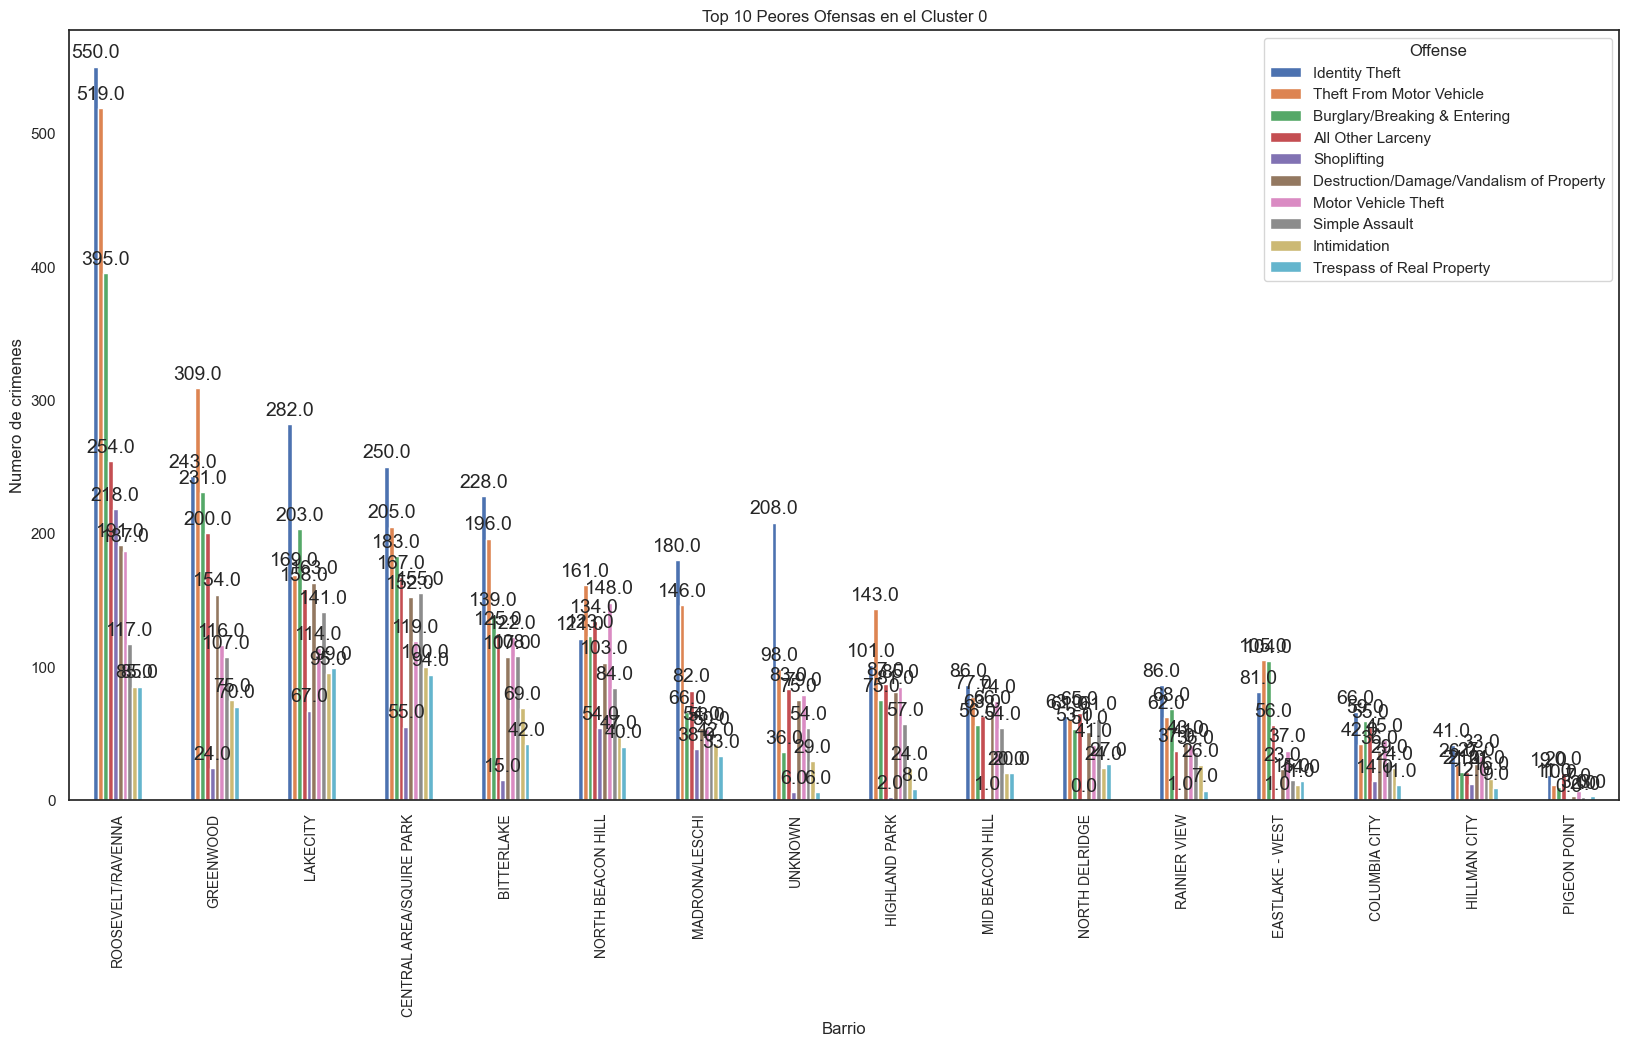

In [35]:
# Visualizamos el top 10 de las peores ofensas de los distriton en el cluster 0
ax = crime_cluster0_plot.plot(kind='bar', figsize=(20, 10), rot=0)

ax.set_ylabel('Numero de crimenes') 
ax.set_xlabel('Barrio') 
ax.set_title('Top 10 Peores Ofensas en el Cluster 0') 

# roto xticklabels
ax.set_xticklabels(ax.get_xticklabels(),
                        rotation=90,
                        fontweight='light',
                        fontsize='small'
                        )

# config de las barras
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

### Cluster 1

In [36]:
#Creamos una grafica sobre el top 10 de los crimenes del cluster 1
wa_cluster[1].sort_values(ascending=False)

District
QUEEN ANNE                        4481
CAPITOL HILL                      4464
SLU/CASCADE                       3235
UNIVERSITY                        3192
BALLARD SOUTH                     3004
FIRST HILL                        2548
BELLTOWN                          1762
FREMONT                           1412
SODO                              1243
JUDKINS PARK/NORTH BEACON HILL     768
SOUTH DELRIDGE                     260
EASTLAKE - EAST                    119
Name: Count of Offenses, dtype: int64

In [37]:
# Creo una grafica del top 10 de los crimenes de los distritos del cluster 1
cluster1districts = ["QUEEN ANNE", "CAPITOL HILL", "SLU/CASCADE", "UNIVERSITY", "BALLARD SOUTH", "FIRST HILL", "BELLTOWN", "FREMONT", "SODO", "JUDKINS PARK/NORTH BEACON HILL", "SOUTH DELRIDGE", "EASTLAKE - EAST"]
crime_cluster1 = pd.DataFrame(crime_pivot.loc[cluster1districts,:].transpose()) 
crime_cluster1.drop(axis=0, index=["Total"], inplace=True) 
crime_cluster1_sort = crime_cluster1.sort_values(by=cluster1districts, ascending=False).head(10)
crime_cluster1_plot = crime_cluster1_sort.transpose() 
crime_cluster1_plot

Offense,Theft From Motor Vehicle,Burglary/Breaking & Entering,Identity Theft,All Other Larceny,Destruction/Damage/Vandalism of Property,Motor Vehicle Theft,Simple Assault,Trespass of Real Property,Theft From Building,Theft of Motor Vehicle Parts or Accessories
District,,,,,,,,,,
QUEEN ANNE,843.0,799.0,576.0,360.0,325.0,230.0,207.0,155.0,124.0,122.0
CAPITOL HILL,355.0,642.0,314.0,280.0,369.0,186.0,371.0,321.0,185.0,45.0
SLU/CASCADE,342.0,500.0,213.0,248.0,282.0,77.0,268.0,178.0,138.0,16.0
UNIVERSITY,481.0,486.0,93.0,299.0,345.0,170.0,226.0,135.0,92.0,46.0
BALLARD SOUTH,492.0,485.0,275.0,314.0,230.0,193.0,124.0,100.0,67.0,89.0
FIRST HILL,247.0,358.0,136.0,170.0,229.0,102.0,287.0,250.0,132.0,30.0
BELLTOWN,249.0,259.0,105.0,114.0,159.0,24.0,204.0,79.0,78.0,8.0
FREMONT,242.0,271.0,149.0,157.0,112.0,144.0,50.0,20.0,29.0,44.0
SODO,221.0,115.0,36.0,90.0,139.0,50.0,64.0,64.0,32.0,60.0


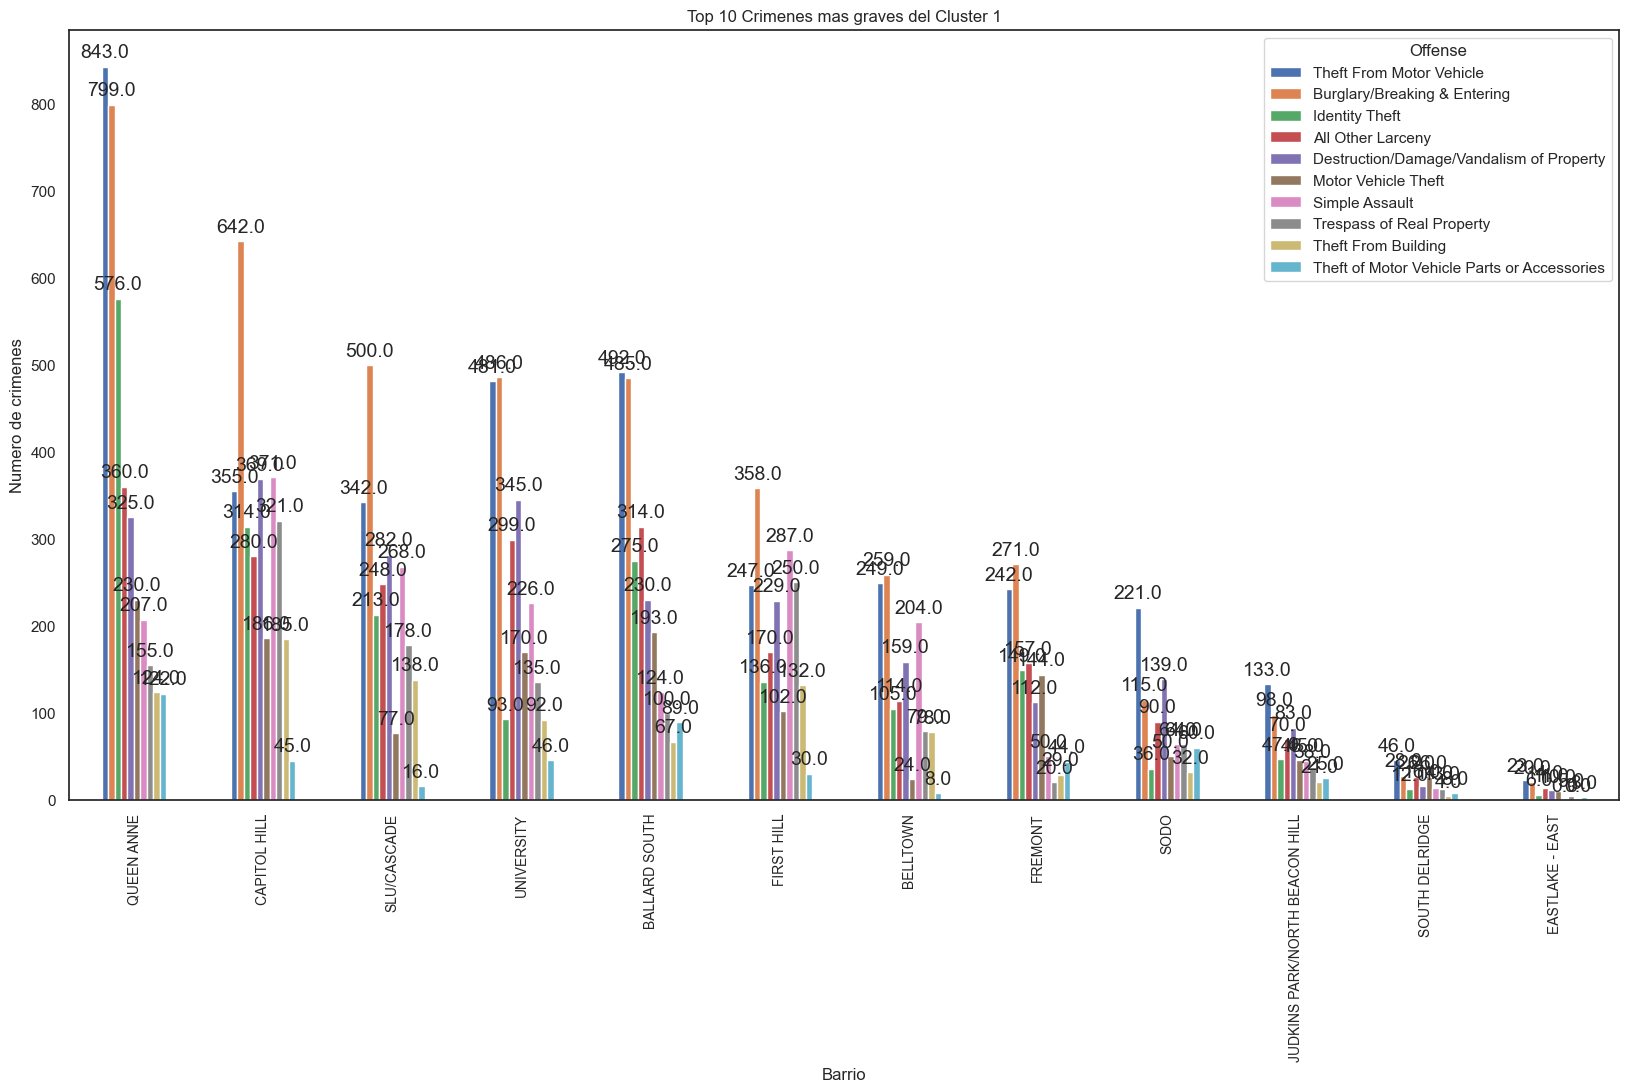

In [38]:
# Visualizamos el top 10 de las peores ofensas de los distriton en el cluster 0
ax = crime_cluster1_plot.plot(kind='bar', figsize=(20, 10), rot=0)

ax.set_ylabel('Numero de crimenes') # add to x-label to the plot
ax.set_xlabel('Barrio') # add y-label to the plot
ax.set_title('Top 10 Crimenes mas graves del Cluster 1') # add title to the plot

# rotate xticklabels
ax.set_xticklabels(ax.get_xticklabels(),
                        rotation=90,
                        fontweight='light',
                        fontsize='small'
                        )

# Annotate the bars 
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

### Cluster 2

In [39]:
# Obtengo los distritos de forma descendiente por cantidad de crimenes del Cluster 2
wa_cluster[2].sort_values(ascending=False)

District
DOWNTOWN COMMERCIAL                 5344
NORTHGATE                           3978
CHINATOWN/INTERNATIONAL DISTRICT    2266
PIONEER SQUARE                      1328
ROXHILL/WESTWOOD/ARBOR HEIGHTS      1165
MOUNT BAKER                         1019
HIGH POINT                           629
RAINIER BEACH                        565
NEW HOLLY                            396
CLAREMONT/RAINIER VISTA              373
GENESEE                              190
Name: Count of Offenses, dtype: int64

In [40]:
#repito lo mismo que se hizo de forma anterior para agrupar distritos y crimenes
cluster2districts = ["DOWNTOWN COMMERCIAL", "NORTHGATE", "CHINATOWN/INTERNATIONAL DISTRICT", "PIONEER SQUARE", "ROXHILL/WESTWOOD/ARBOR HEIGHTS", "MOUNT BAKER", "HIGH POINT", "RAINIER BEACH", "NEW HOLLY", "CLAREMONT/RAINIER VISTA", "GENESEE"]
crime_cluster2 = pd.DataFrame(crime_pivot.loc[cluster2districts,:].transpose()) 
crime_cluster2.drop(axis=0, index=["Total"], inplace=True) 
crime_cluster2_sort = crime_cluster2.sort_values(by=cluster2districts, ascending=False).head(10)
crime_cluster2_plot = crime_cluster2_sort.transpose() 
crime_cluster2_plot

Offense,Shoplifting,Simple Assault,Theft From Motor Vehicle,Trespass of Real Property,Burglary/Breaking & Entering,Destruction/Damage/Vandalism of Property,Drug/Narcotic Violations,Aggravated Assault,All Other Larceny,Intimidation
District,,,,,,,,,,
DOWNTOWN COMMERCIAL,699.0,545.0,518.0,466.0,391.0,340.0,280.0,279.0,270.0,255.0
NORTHGATE,372.0,196.0,480.0,166.0,384.0,261.0,69.0,91.0,333.0,151.0
CHINATOWN/INTERNATIONAL DISTRICT,429.0,169.0,205.0,205.0,223.0,183.0,85.0,112.0,97.0,88.0
PIONEER SQUARE,14.0,223.0,129.0,75.0,93.0,146.0,34.0,104.0,100.0,61.0
ROXHILL/WESTWOOD/ARBOR HEIGHTS,138.0,89.0,141.0,22.0,93.0,91.0,9.0,26.0,95.0,52.0
MOUNT BAKER,120.0,62.0,119.0,44.0,65.0,74.0,9.0,49.0,79.0,52.0
HIGH POINT,48.0,90.0,49.0,16.0,41.0,56.0,7.0,28.0,58.0,32.0
RAINIER BEACH,47.0,65.0,36.0,16.0,39.0,46.0,7.0,48.0,37.0,26.0
NEW HOLLY,40.0,30.0,24.0,13.0,25.0,34.0,5.0,26.0,35.0,18.0


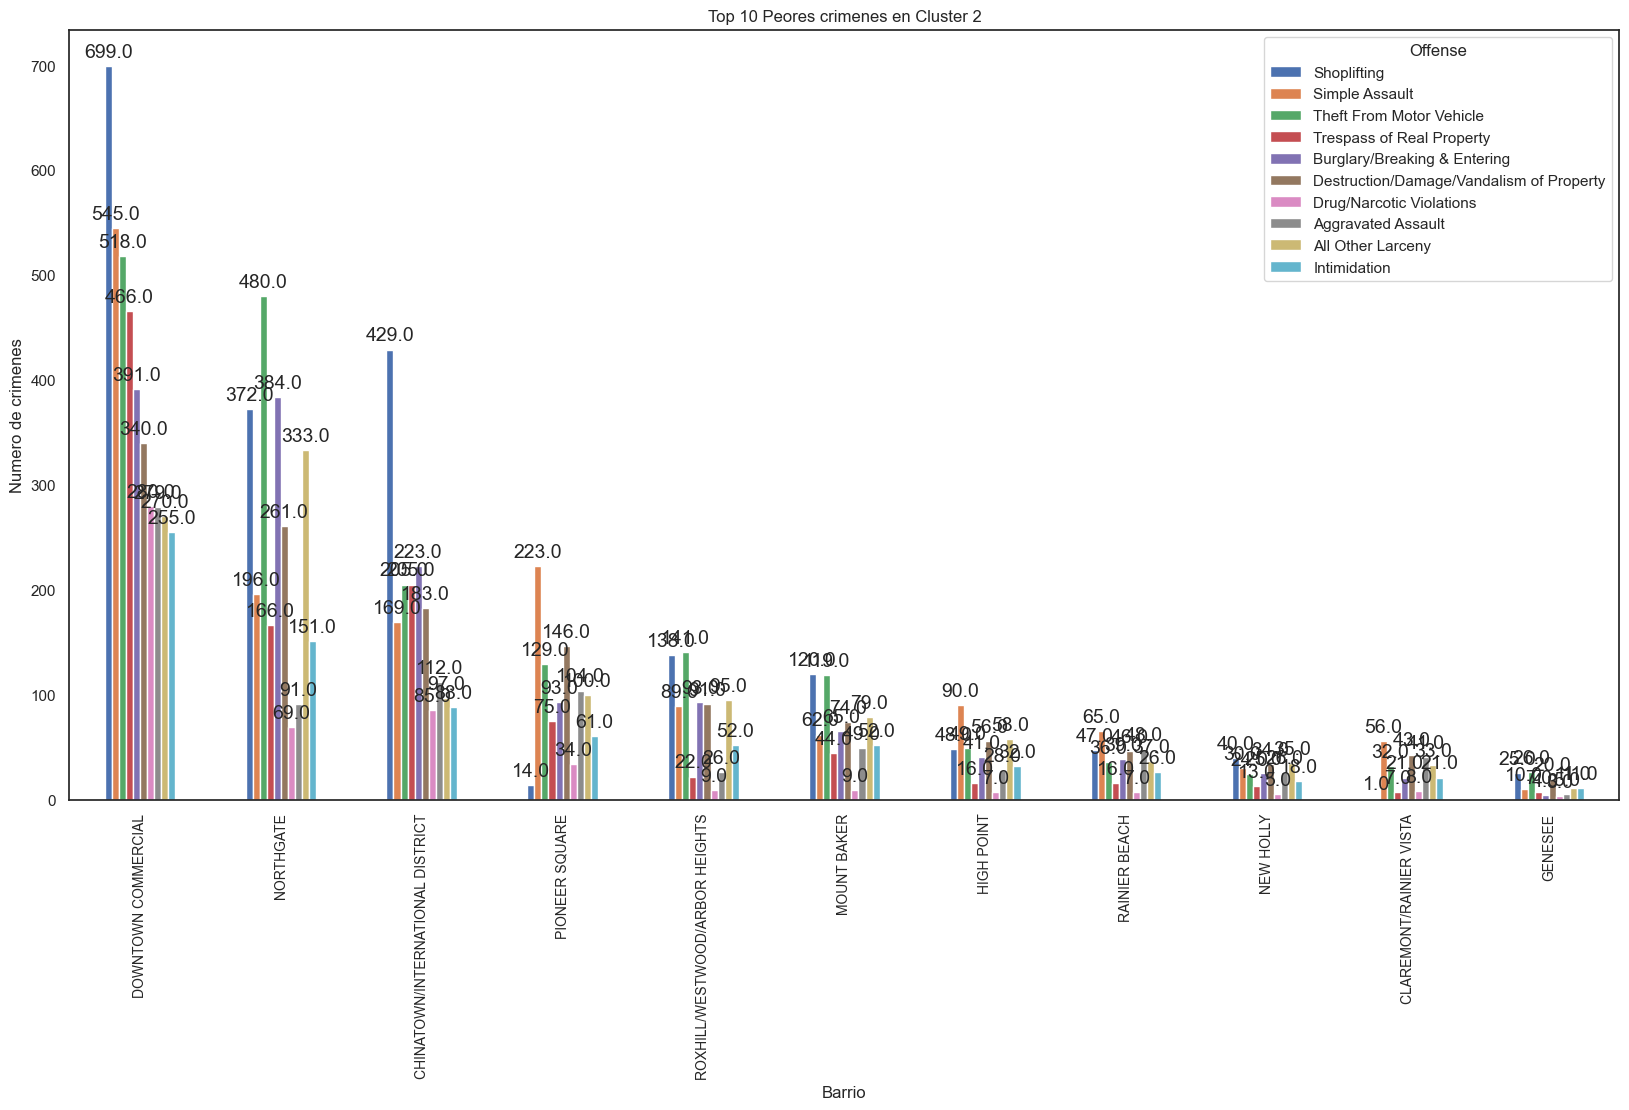

In [41]:
# Creo nuevamente la grafica como en los clusters anteriores
ax = crime_cluster2_plot.plot(kind='bar', figsize=(20, 10), rot=0)

ax.set_ylabel('Numero de crimenes') 
ax.set_xlabel('Barrio') 
ax.set_title('Top 10 Peores crimenes en Cluster 2') 

ax.set_xticklabels(ax.get_xticklabels(),
                        rotation=90,
                        fontweight='light',
                        fontsize='small'
                        )

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

### Cluster 3

In [42]:
# Obtengo los distritos de forma descendiente por cantidad de crimenes del Cluster 3
wa_cluster[3].sort_values(ascending=False)

District
SANDPOINT               2261
BALLARD NORTH           1752
MAGNOLIA                1489
WALLINGFORD             1385
NORTH ADMIRAL            792
MORGAN                   791
PHINNEY RIDGE            741
MILLER PARK              562
MONTLAKE/PORTAGE BAY     532
FAUNTLEROY SW            395
LAKEWOOD/SEWARD PARK     374
ALKI                     373
MADISON PARK             320
Name: Count of Offenses, dtype: int64

In [43]:
# Repetimos el analisis hasta llegar a la grafica como en los clusters anteriores
cluster3districts = ["SANDPOINT", "BALLARD NORTH", "MAGNOLIA", "WALLINGFORD", "MORGAN", "MILLER PARK", "MONTLAKE/PORTAGE BAY", "FAUNTLEROY SW", "LAKEWOOD/SEWARD PARK", "ALKI", "MADISON PARK"]
crime_cluster3 = pd.DataFrame(crime_pivot.loc[cluster3districts,:].transpose()) 
crime_cluster3.drop(axis=0, index=["Total"], inplace=True) 
crime_cluster3_sort = crime_cluster3.sort_values(by=cluster3districts, ascending=False).head(10)
crime_cluster3_plot = crime_cluster3_sort.transpose() 
crime_cluster3_plot

Offense,Identity Theft,Theft From Motor Vehicle,Burglary/Breaking & Entering,All Other Larceny,Destruction/Damage/Vandalism of Property,Motor Vehicle Theft,Simple Assault,Intimidation,Theft of Motor Vehicle Parts or Accessories,Aggravated Assault
District,,,,,,,,,,
SANDPOINT,779.0,369.0,190.0,179.0,125.0,110.0,89.0,64.0,44.0,44.0
BALLARD NORTH,528.0,257.0,165.0,151.0,112.0,124.0,54.0,38.0,52.0,23.0
MAGNOLIA,348.0,251.0,168.0,112.0,109.0,106.0,64.0,53.0,40.0,35.0
WALLINGFORD,316.0,228.0,226.0,114.0,80.0,121.0,33.0,33.0,57.0,18.0
MORGAN,204.0,108.0,66.0,59.0,64.0,87.0,24.0,30.0,19.0,18.0
MILLER PARK,131.0,89.0,68.0,46.0,37.0,28.0,25.0,19.0,12.0,15.0
MONTLAKE/PORTAGE BAY,155.0,111.0,62.0,51.0,36.0,23.0,10.0,10.0,13.0,7.0
FAUNTLEROY SW,98.0,108.0,30.0,35.0,28.0,28.0,13.0,6.0,6.0,8.0
LAKEWOOD/SEWARD PARK,99.0,92.0,36.0,40.0,20.0,19.0,8.0,8.0,9.0,4.0


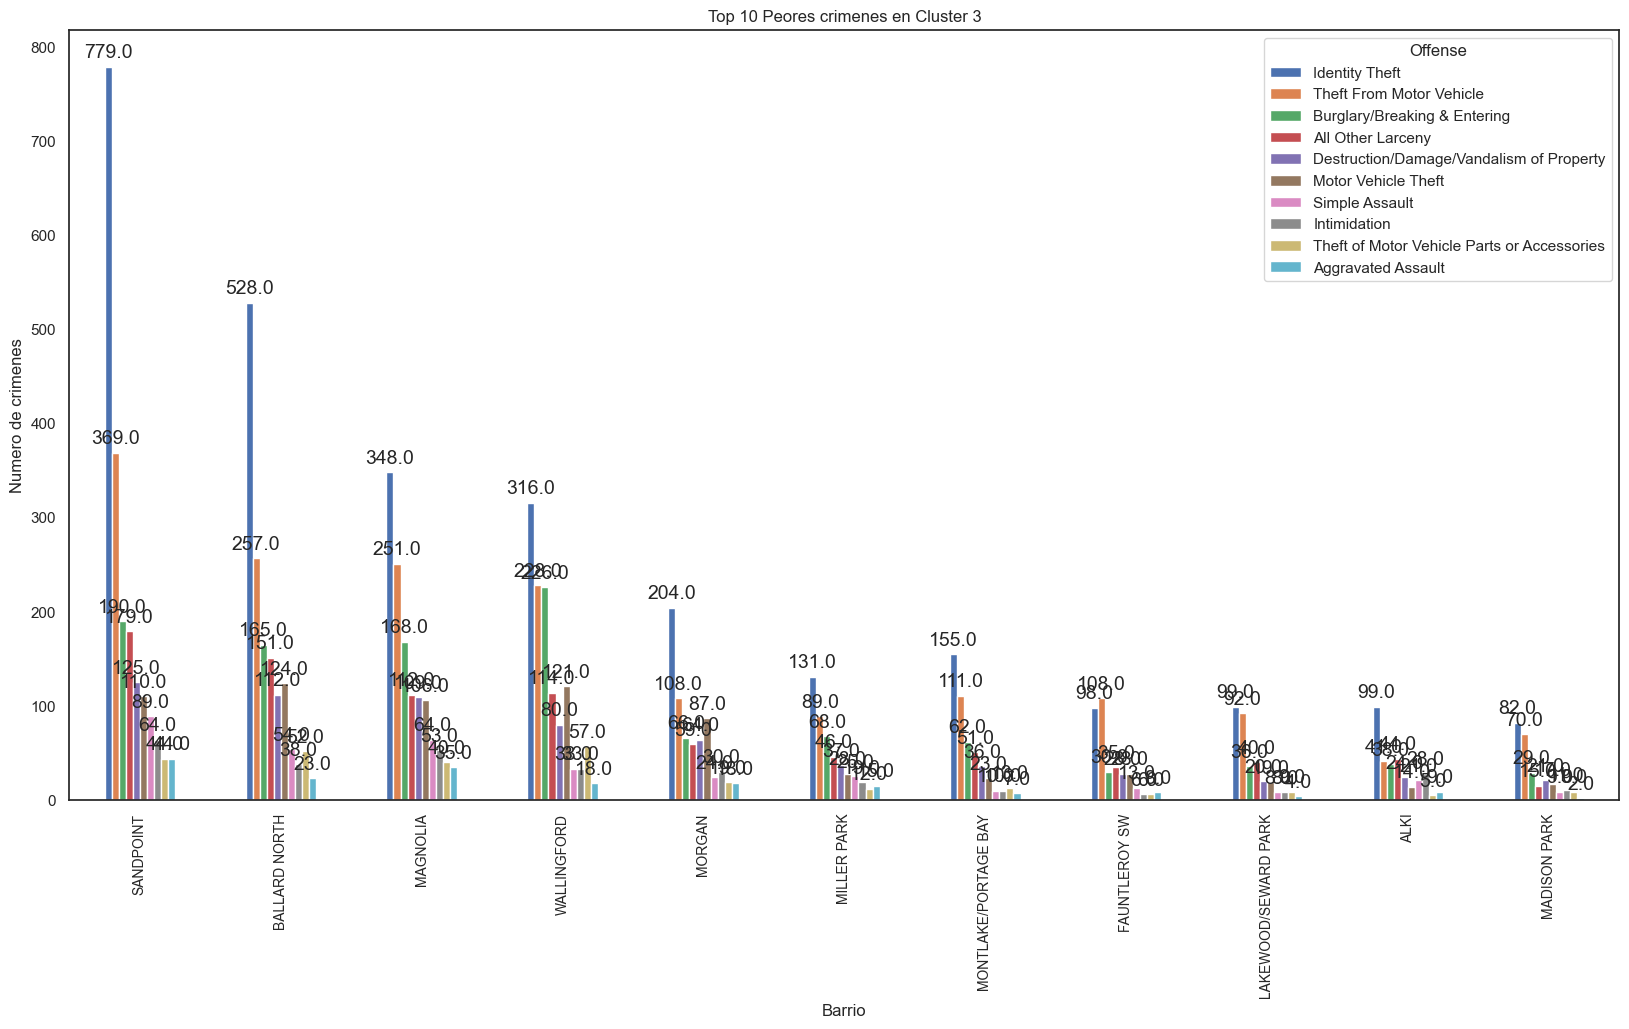

In [44]:
ax = crime_cluster3_plot.plot(kind='bar', figsize=(20, 10), rot=0)

ax.set_ylabel('Numero de crimenes') 
ax.set_xlabel('Barrio') 
ax.set_title('Top 10 Peores crimenes en Cluster 3') 

# rotate xticklabels
ax.set_xticklabels(ax.get_xticklabels(),
                        rotation=90,
                        fontweight='light',
                        fontsize='small'
                        )

# Annotate the bars 
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

### Cluster 4

In [45]:
# Obtengo los distritos de forma descendiente por cantidad de crimenes del Cluster 4
wa_cluster[4].sort_values(ascending=False)

District
GEORGETOWN                  1003
BRIGHTON/DUNLAP              894
SOUTH PARK                   584
SOUTH BEACON HILL            294
COMMERCIAL DUWAMISH           49
COMMERCIAL HARBOR ISLAND      35
Name: Count of Offenses, dtype: int64

In [46]:
# Repetimos el analisis hasta llegar a la grafica como en los clusters anteriores
cluster4districts = ["COMMERCIAL DUWAMISH", "COMMERCIAL HARBOR ISLAND","GEORGETOWN","BRIGHTON/DUNLAP","SOUTH PARK","SOUTH BEACON HILL"]
crime_cluster4 = pd.DataFrame(crime_pivot.loc[cluster4districts,:].transpose()) #slicing to get just districts in cluster 4
crime_cluster4.drop(axis=0, index=["Total"], inplace=True) #drop to Total row
crime_cluster4_sort = crime_cluster4.sort_values(by=cluster4districts, ascending=False).head(10)
crime_cluster4_plot = crime_cluster4_sort.transpose() #transpose to switch rows and columns
crime_cluster4_plot

Offense,Burglary/Breaking & Entering,Driving Under the Influence,All Other Larceny,Theft of Motor Vehicle Parts or Accessories,Destruction/Damage/Vandalism of Property,Aggravated Assault,Theft From Motor Vehicle,Motor Vehicle Theft,Trespass of Real Property,Identity Theft
District,,,,,,,,,,
COMMERCIAL DUWAMISH,9.0,7.0,6.0,5.0,4.0,4.0,3.0,2.0,2.0,1.0
COMMERCIAL HARBOR ISLAND,2.0,9.0,7.0,NaN,3.0,3.0,2.0,3.0,NaN,1.0
GEORGETOWN,99.0,30.0,113.0,57.0,134.0,42.0,85.0,88.0,36.0,39.0
BRIGHTON/DUNLAP,85.0,30.0,81.0,25.0,95.0,73.0,57.0,110.0,11.0,57.0
SOUTH PARK,88.0,9.0,52.0,18.0,65.0,34.0,41.0,95.0,14.0,17.0
SOUTH BEACON HILL,37.0,14.0,31.0,17.0,22.0,14.0,23.0,19.0,5.0,25.0


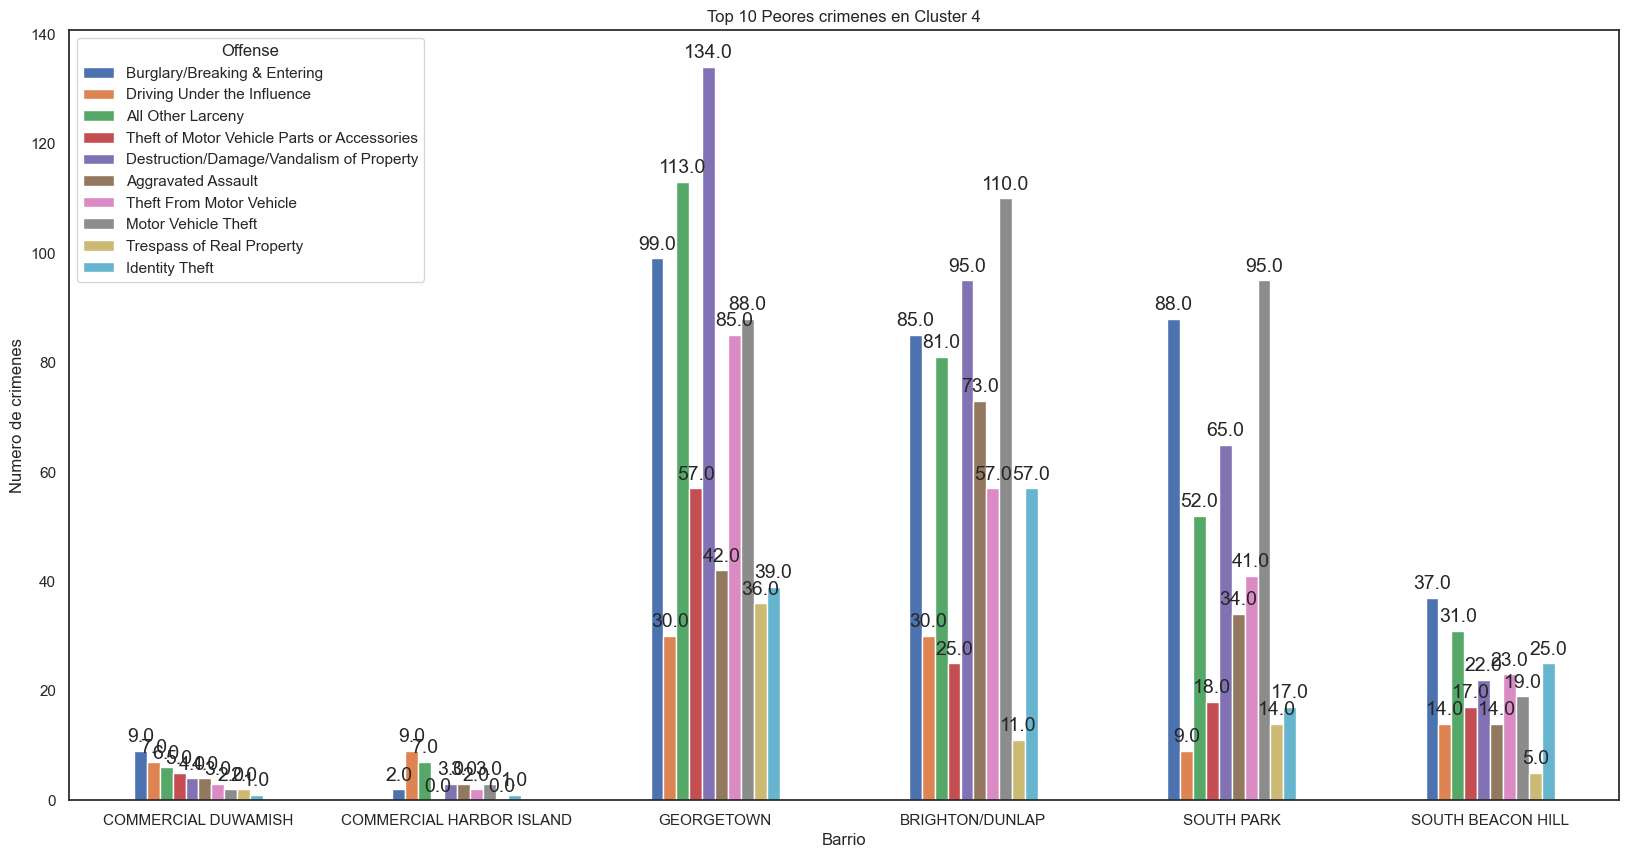

In [47]:
ax = crime_cluster4_plot.plot(kind='bar', figsize=(20, 10), rot=0)

ax.set_ylabel('Numero de crimenes')
ax.set_xlabel('Barrio') 
ax.set_title('Top 10 Peores crimenes en Cluster 4') 

# Annotate the bars 
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

Dado que los clusters 0, 1 y 2 contienen distritos que estan en la lista de los top 10 distritos con mas crimenes en total y Cluster 4 es en mayoría area comercial. Seleccionaré el cluster 3 para buscar un barrio adecuado para vivir.

### Busqueda de un barrio para vivir dentro del cluster 3

Dado que los distritos del grupo 3 han sido elegidos como la parte más segura de Seattle para vivir, ahora nos gustaría echar un vistazo más de cerca a los vecindarios dentro de estos distritos. Queremos ver los lugares en los vecindarios usando la API de Foursquare y reducir nuestra búsqueda del vecindario más adecuado para vivir.

Primero, obtendremos los vecindarios que se encuentran dentro de los distritos del Clúster 3, junto con sus coordenadas, y los colocaremos en un marco de datos de pandas. Los distritos que no tienen vecindarios tendrán el nombre del distrito como nombre del vecindario.

In [48]:
# limpio manualmente los nombres de los distritos para que coincidan con mayor precisión con los distritos en seatle_data
cluster3districts_rev = ["SANDPOINT", "NORTH BALLARD", "MAGNOLIA", "WALLINGFORD", "MADRONA", "LESCHI", "NORTH ADMIRAL", "MORGAN", "PHINNEY RIDGE", "MILLER PARK", "MONTLAKE", "PORTAGE BAY", "FAUNTLEROY", "LAKEWOOD", "SEWARD PARK", "ALKI", "MADISON PARK", "PIGEON POINT"]
# Agrego un "or" en la lista de cluster3districts_rev
search_list = '|'.join(cluster3districts_rev)

# Paso todos los nombres a mayusculas
seatle_data["Barrio"] = seatle_data["Barrio"].str.upper()
seatle_data["Distrito"] = seatle_data["Distrito"].str.upper()

# hago un check de los tipos de datos
print(seatle_data.dtypes)
# verifico que todo esta correcto
seatle_data.head()

Barrio       object
Distrito     object
Latitud     float64
Longitud    float64
dtype: object


,Barrio,Distrito,Latitud,Longitud
0,NORTH SEATTLE,SEATTLE,47.643724,-122.302965
1,BROADVIEW,NORTH SEATTLE,47.722380,-122.364980
2,BITTER LAKE,NORTH SEATTLE,47.718680,-122.350300
3,NORTH BEACH / BLUE RIDGE,NORTH SEATTLE,47.700440,-122.384180
4,CROWN HILL,NORTH SEATTLE,47.695200,-122.374100


In [49]:
#Busco y filtro en la lista por los barrios del cluster 3
wa_data_temp1 = seatle_data[seatle_data["Barrio"].str.contains(search_list)]
wa_data_temp1

,Barrio,Distrito,Latitud,Longitud
28,WALLINGFORD,NORTH SEATTLE,47.655550,-122.326500
32,PHINNEY RIDGE,NORTH SEATTLE,47.675960,-122.354360
40,MAGNOLIA,CENTRAL SEATTLE,47.614045,-122.182486
43,SOUTHEAST MAGNOLIA,MAGNOLIA,47.641170,-122.391770
51,PORTAGE BAY,CAPITOL HILL,47.646900,-122.320280
54,MONTLAKE,CAPITOL HILL,47.640850,-122.302070
59,MADISON PARK,CAPITOL HILL,47.635010,-122.278570
83,MADRONA,CENTRAL AREA,47.612930,-122.289680
84,MADRONA VALLEY,MADRONA,46.905066,-122.383706
87,LESCHI,CENTRAL AREA,47.601500,-122.291340


In [50]:
#Busco y filtro en la lista por los distritos del cluster 3
wa_data_temp2 = seatle_data[seatle_data["Distrito"].str.contains(search_list)]
wa_data_temp2

,Barrio,Distrito,Latitud,Longitud
29,NORTHLAKE,"LAKE UNION / LOWER WALLINGFORD, SPILLING OVER ...",47.304470,-122.290320
41,LAWTON PARK,MAGNOLIA,47.659080,-122.400920
42,BRIARCLIFF,MAGNOLIA,47.645000,-122.407740
43,SOUTHEAST MAGNOLIA,MAGNOLIA,47.641170,-122.391770
60,BROADMOOR,MADISON PARK,47.632820,-122.288270
84,MADRONA VALLEY,MADRONA,46.905066,-122.383706
98,LAKEWOOD,SEWARD PARK,47.161950,-122.514930


In [51]:
#combino ambos data set
cluster3_data = pd.concat([wa_data_temp1, wa_data_temp2]).drop_duplicates().reset_index(drop=True)
cluster3_data

,Barrio,Distrito,Latitud,Longitud
0,WALLINGFORD,NORTH SEATTLE,47.655550,-122.326500
1,PHINNEY RIDGE,NORTH SEATTLE,47.675960,-122.354360
2,MAGNOLIA,CENTRAL SEATTLE,47.614045,-122.182486
3,SOUTHEAST MAGNOLIA,MAGNOLIA,47.641170,-122.391770
4,PORTAGE BAY,CAPITOL HILL,47.646900,-122.320280
5,MONTLAKE,CAPITOL HILL,47.640850,-122.302070
6,MADISON PARK,CAPITOL HILL,47.635010,-122.278570
7,MADRONA,CENTRAL AREA,47.612930,-122.289680
8,MADRONA VALLEY,MADRONA,46.905066,-122.383706
9,LESCHI,CENTRAL AREA,47.601500,-122.291340


Ahora que tenemos un marco de datos que contiene todos los vecindarios del Cluster 3, queremos ver los lugares cercanos a ellos.

Funcion que se utilizara para revisar los datos de los lugares cercanos dentro de un radio de 1600 metros aproximadamente una milla

In [52]:
def getNearbyVenues(names, latitudes, longitudes, radius=1609, limit=50):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # Creo la URL de request de la api
        explore_url_prefix = 'https://api.foursquare.com/v3/places/search'

        url = '{}?ll={}%2C{}&radius={}&limit={}'.format(
        explore_url_prefix, 
        lat, lng, radius,limit)

        headers = {
            "accept": "application/json",
            "Authorization": "fsq3QU7ZPPlgHjAHxcrxXMqjXTt7QlulQ320poEiVv/qGD0="
        }

        # Hago la request de Get
        results = requests.get(url,headers=headers).json()["results"]
        no_category = 'No Category'

        for v in results:
            if len(v['categories']):
                venues_list.append((
                name, lat, lng,
                v['name'], 
                v['geocodes']['main']['latitude'], 
                v['geocodes']['main']['longitude'],  
                v['categories'][0]['name']))
            else:
                venues_list.append((
                name, lat, lng,
                v['name'], 
                v['geocodes']['main']['latitude'], 
                v['geocodes']['main']['longitude'],  
                no_category))
        

    nearby_venues = pd.DataFrame(venues_list)
    nearby_venues.columns = [
    'Barrio', 'Barrio Latitud', 'Barrio Longitud', 
    'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

Uso la función getNearbyVenues en cada vecindario y cree un nuevo marco de datos llamado cluster3_venues

In [53]:

seatle_venues = getNearbyVenues(names=cluster3_data['Barrio'],
                                   latitudes=cluster3_data['Latitud'],
                                   longitudes=cluster3_data['Longitud']
                                  )

WALLINGFORD
PHINNEY RIDGE
MAGNOLIA
SOUTHEAST MAGNOLIA
PORTAGE BAY
MONTLAKE
MADISON PARK
MADRONA
MADRONA VALLEY
LESCHI
SEWARD PARK
LAKEWOOD
ALKI POINT
NORTH ADMIRAL
FAUNTLEROY
PIGEON POINT
NORTHLAKE
LAWTON PARK
BRIARCLIFF
BROADMOOR


Verifiquemos el tamaño del marco de datos resultante.

In [54]:
print(seatle_venues.shape)
seatle_venues.head()

(910, 7)


,Barrio,Barrio Latitud,Barrio Longitud,Venue,Venue Latitude,Venue Longitude,Venue Category
0,WALLINGFORD,47.65555,-122.3265,Ivar's Salmon House,47.653664,-122.324177,American Restaurant
1,WALLINGFORD,47.65555,-122.3265,Ivars Fish Bar,47.653714,-122.323941,Seafood Restaurant
2,WALLINGFORD,47.65555,-122.3265,Voula's Offshore Cafe,47.654636,-122.321453,Café
3,WALLINGFORD,47.65555,-122.3265,Westward,47.651790,-122.328831,American Restaurant
4,WALLINGFORD,47.65555,-122.3265,Whalemaker Lounge,47.653540,-122.323928,Cocktail Bar


Veamos cuantos lugares se devolvieron para cada barrio

In [55]:
seatle_venues.groupby('Barrio').count()

,Barrio Latitud,Barrio Longitud,Venue,Venue Latitude,Venue Longitude,Venue Category
Barrio,,,,,,
ALKI POINT,50,50,50,50,50,50
BRIARCLIFF,50,50,50,50,50,50
BROADMOOR,50,50,50,50,50,50
FAUNTLEROY,50,50,50,50,50,50
LAKEWOOD,50,50,50,50,50,50
LAWTON PARK,50,50,50,50,50,50
LESCHI,50,50,50,50,50,50
MADISON PARK,50,50,50,50,50,50
MADRONA,50,50,50,50,50,50


Averiguemos cuantas categorias anicas se pueden seleccionar de todos los lugares devueltos


In [56]:
print('Existen {} categorias unicas.'.format(len(seatle_venues['Venue Category'].unique())))


Existen 198 categorias unicas.


Veamos un mapa de dónde están todos estos lugares.

In [57]:
map_cluster3venues = folium.Map(location=[latitude_seattle, longitude_seattle], zoom_start=10)

for lat, lng, category, name in zip(seatle_venues['Venue Latitude'], seatle_venues['Venue Longitude'], seatle_venues['Venue Category'], seatle_venues['Venue']):
    label = '{}, {}'.format(category, name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#ffff00',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cluster3venues)  
    
map_cluster3venues

Ahora analicemos cada barrio del Cluster 3, según las sedes

In [58]:

wa3_onehot = pd.get_dummies(seatle_venues[['Venue Category']], prefix="", prefix_sep="")

# agrego la columan barrio al conjunto de datos como la primera columna
#wa3_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
wa3_onehot.insert(0, 'Barrio', seatle_venues["Barrio"])

wa3_onehot.head()

,Barrio,ATM,Accounting and Bookkeeping Service,Advertising Agency,Afghan Restaurant,African Restaurant,Alternative Medicine Clinic,American Restaurant,Arcade,Art Gallery,...,Thai Restaurant,Toy / Game Store,Travel Agency,Urban Park,Vegan and Vegetarian Restaurant,Video Store,Vietnamese Restaurant,Vintage and Thrift Store,Wine Bar,Zoo
0,WALLINGFORD,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,WALLINGFORD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,WALLINGFORD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,WALLINGFORD,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,WALLINGFORD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Tamaño del data frame

In [59]:
wa3_onehot.shape

(910, 199)

A continuación, agrupemos las filas por vecindario y tomando la media de la frecuencia de ocurrencia de cada categoría

In [60]:
wa3_grouped = wa3_onehot.groupby('Barrio').mean().reset_index()
wa3_grouped

,Barrio,ATM,Accounting and Bookkeeping Service,Advertising Agency,Afghan Restaurant,African Restaurant,Alternative Medicine Clinic,American Restaurant,Arcade,Art Gallery,...,Thai Restaurant,Toy / Game Store,Travel Agency,Urban Park,Vegan and Vegetarian Restaurant,Video Store,Vietnamese Restaurant,Vintage and Thrift Store,Wine Bar,Zoo
0,ALKI POINT,0.00,0.00,0.02,0.00,0.00,0.00,0.040000,0.00,0.02,...,0.00,0.00,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.0
1,BRIARCLIFF,0.04,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.02,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
2,BROADMOOR,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,...,0.00,0.00,0.00,0.04,0.02,0.00,0.00,0.00,0.02,0.0
3,FAUNTLEROY,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.02,...,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.0
4,LAKEWOOD,0.00,0.00,0.00,0.00,0.00,0.00,0.040000,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.0
5,LAWTON PARK,0.00,0.00,0.00,0.00,0.00,0.00,0.020000,0.00,0.00,...,0.02,0.00,0.00,0.02,0.00,0.02,0.00,0.00,0.00,0.0
6,LESCHI,0.00,0.00,0.00,0.00,0.04,0.00,0.040000,0.00,0.00,...,0.02,0.00,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.0
7,MADISON PARK,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.02,...,0.02,0.02,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.0
8,MADRONA,0.00,0.00,0.00,0.00,0.06,0.02,0.020000,0.00,0.02,...,0.06,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.0
9,MADRONA VALLEY,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0


Vemos de nuevo el tamaño del conjunto de datos

In [61]:
wa3_grouped.shape


(20, 199)

Imprimamos cada barrio junto con los 5 lugares más comunes

In [62]:
num_top_venues = 5

for barrio in wa3_grouped['Barrio']:
    print("++++"+barrio+"++++")
    temp = wa3_grouped[wa3_grouped['Barrio'] == barrio].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

++++ALKI POINT++++
                 venue  freq
0           Urban Park  0.08
1   Italian Restaurant  0.04
2          Coffee Shop  0.04
3                  Bar  0.04
4  Fish and Chips Shop  0.04


++++BRIARCLIFF++++
            venue  freq
0    Hiking Trail  0.06
1      Playground  0.06
2            Bank  0.04
3  Scenic Lookout  0.04
4        Pizzeria  0.04


++++BROADMOOR++++
          venue  freq
0        Garden  0.12
1        Bakery  0.06
2          Park  0.06
3  Hiking Trail  0.04
4    Playground  0.04


++++FAUNTLEROY++++
          venue  freq
0          Park  0.06
1    Hair Salon  0.06
2         Beach  0.06
3    Playground  0.06
4  Hiking Trail  0.04


++++LAKEWOOD++++
                  venue  freq
0        Clothing Store  0.08
1  Fast Food Restaurant  0.06
2              Pizzeria  0.06
3      Department Store  0.06
4          Burger Joint  0.06


++++LAWTON PARK++++
                 venue  freq
0         Cocktail Bar  0.14
1         Hiking Trail  0.06
2         Burger Joint  0.06


Pongamos esto en un marco de datos de pandas para que sea más fácil de leer.

Pero primero, definamos una función que clasificará los lugares en orden descendente.

In [63]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Ahora podemos crear el marco de datos que muestra los 10 mejores lugares para cada vecindario.

In [64]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Barrio']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
wa3_neigh_venues_sorted = pd.DataFrame(columns=columns)
wa3_neigh_venues_sorted['Barrio'] = wa3_grouped['Barrio']

for ind in np.arange(wa3_grouped.shape[0]):
    wa3_neigh_venues_sorted.iloc[ind, 1:] = return_most_common_venues(wa3_grouped.iloc[ind, :], num_top_venues)

wa3_neigh_venues_sorted

,Barrio,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALKI POINT,Urban Park,Italian Restaurant,Coffee Shop,Bar,Fish and Chips Shop,Monument,Pizzeria,Beach,American Restaurant,Restaurant
1,BRIARCLIFF,Hiking Trail,Playground,Bank,Scenic Lookout,Pizzeria,Park,Grocery Store / Supermarket,Coffee Shop,ATM,Farmers' Market
2,BROADMOOR,Garden,Bakery,Park,Hiking Trail,Playground,Coffee Shop,Restaurant,Bank,Pizzeria,Urban Park
3,FAUNTLEROY,Park,Hair Salon,Beach,Playground,Hiking Trail,Restaurant,Attorney / Law Office,Urban Park,No Category,Coffee Shop
4,LAKEWOOD,Clothing Store,Fast Food Restaurant,Pizzeria,Department Store,Burger Joint,Bar,Furniture and Home Store,Coffee Shop,Grocery Store / Supermarket,American Restaurant
5,LAWTON PARK,Cocktail Bar,Hiking Trail,Burger Joint,Japanese Restaurant,Beer Bar,Café,Mexican Restaurant,Bakery,Playground,Brewery
6,LESCHI,Urban Park,Playground,Bar,Coffee Shop,Grocery Store / Supermarket,Café,Cocktail Bar,Bakery,Fried Chicken Joint,American Restaurant
7,MADISON PARK,Hair Salon,Spa,Park,Bank,Bakery,Furniture and Home Store,Bookstore,Hair Removal Service,Sports Bar,Grocery Store / Supermarket
8,MADRONA,Coffee Shop,Thai Restaurant,African Restaurant,Bar,Dry Cleaner,Playground,Urban Park,Bakery,Fried Chicken Joint,Café
9,MADRONA VALLEY,Industrial Equipment Supplier,ATM,Music Venue,Mediterranean Restaurant,Mental Health Clinic,Metals Supplier,Mexican Restaurant,Miscellaneous Store,Mobile Phone Store,Monument


Al investigar los lugares en los barrios del Grupo 3, he acotado aún más mi búsqueda de un lugar adecuado para el Valle de Madrona, debido a su proximidad a los restaurantes chinos y de dumplings.